# PMEL/FOCI ERDDAP for Moorings Example

## EcoFOCI Background

EcoFOCI maintains an internal server (or two) that mooring/ctd and other data is served up on.  downdraft/thundersnow is the test server (S.Bell's office) and Akutan is considered the production server (virtual linux system)

## ERDDAP References

more info can be found on the erddapy webpage - https://ioos.github.io/erddapy/quick_intro.html#

In [1]:
#standard imports for this operation
from erddapy import ERDDAP
import pandas as pd
import numpy as np

erddap has two types of data basically... gridded (foci data uses this for 1hr datasets and adcp data) and tabular.  Tabular imports to pandas very nicely as csv files and gridded imports to xarray (via .nc files) nicely.  Of course, more meta information is retained when importing a netcdf file than a csv file if this is important.

In [6]:
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'
did = 'datasets_Mooring_17bsm2a_final'
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

#usally two data bases exist for each deployment, a preliminary and a final
#a gridded may also exist (build from the final tabular dataset) and an ADCP dataset may exist
d.dataset_id=did

#define the variables you want to get
d.variables =  [
 'timeseries_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

# useful if only wanting a small time portion
d.constraints = {
    'time>=': '2017-01-01T00:00:00Z',
    'time<=': '2020-10-10T00:00:00Z',
}

#data download below will fail unitl the variables are named apporpiatly

the following will get variable names by attribute "standard_name" where standard_name is not empty (useful as variables may have different names among datasets, but standard_names are pulled from the CF standard naming convention where available)

In [7]:
d.get_var_by_attr(dataset_id=did,standard_name='sea_water_temperature')

['temperature']

In [8]:
variables = d.get_var_by_attr(
        dataset_id=did,
        standard_name=lambda v: (v is not None)
    )


variables

['pressure',
 'salinity',
 'Oxygen_Saturation',
 'Water_Depth',
 'Chlorophyll_Fluorescence',
 'Oxygen_Concentration',
 'time',
 'longitude',
 'latitude',
 'temperature',
 'depth']

In [9]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = f'<iframe src="{src}" width="100%" height="950"></iframe>'
    return HTML(iframe)

In [10]:
#watch out for deg E conversions - either >180 or <0
kw = {
    'standard_name': 'seawater_temperature',
    'min_lon': 180.0,
    'max_lon': 220.0,
    'min_lat': 50.0,
    'max_lat': 85.0,
}

search_url = d.get_search_url(response='html', **kw)

show_iframe(search_url)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


erddapy really is just a url builder, the following url can be passed into just about any RESTful service

In [11]:
d.variables = variables
download_url = d.get_download_url()

from urllib.parse import urlencode
print(download_url) #not working?

http://akutan.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_17bsm2a_final.csv?pressure,salinity,Oxygen_Saturation,Water_Depth,Chlorophyll_Fluorescence,Oxygen_Concentration,time,longitude,latitude,temperature,depth&time>=1483228800.0&time<=1602288000.0


In [12]:
#download data
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
)

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.head()

,pressure,salinity,Oxygen_Saturation,Water_Depth,Chlorophyll_Fluorescence,Oxygen_Concentration,longitude,latitude,temperature,depth
time (UTC),,,,,,,,,,
2017-04-27 22:00:00+00:00,NaN,31.839,NaN,71.0,NaN,NaN,195.944336,56.86767,-0.422100,50.0
2017-04-27 22:00:00+00:00,NaN,NaN,NaN,71.0,NaN,NaN,195.944336,56.86767,1.578335,4.0
2017-04-27 22:00:00+00:00,NaN,NaN,NaN,71.0,2.029539,NaN,195.944336,56.86767,NaN,24.0
2017-04-27 22:00:00+00:00,NaN,NaN,NaN,71.0,NaN,NaN,195.944336,56.86767,-1.271268,32.0
2017-04-27 22:00:00+00:00,NaN,NaN,NaN,71.0,NaN,NaN,195.944000,56.86770,0.690800,9.0


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

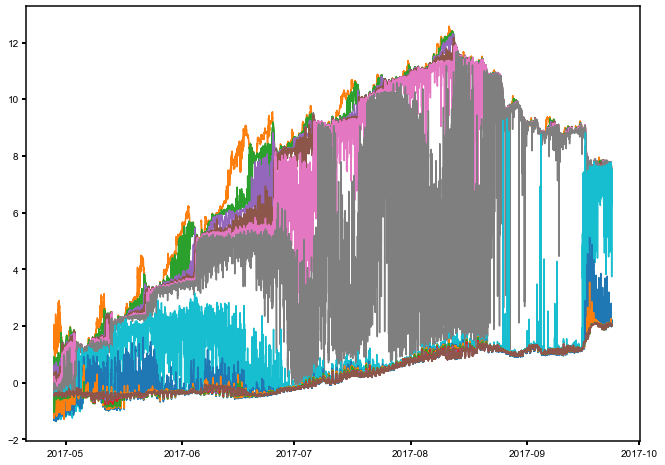

In [18]:
fig, ax = plt.subplots(figsize=(11, 8))
for name,group in df.groupby(df.depth):
    ax.plot(group.index,group.temperature)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


Text(0, 0.5, 'Depth (m)')

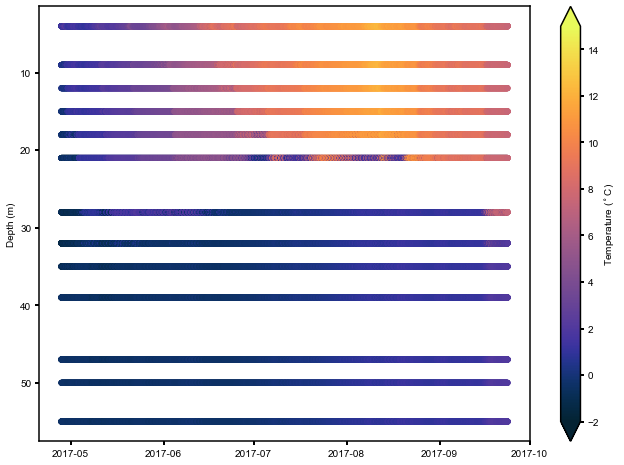

In [19]:
#not gridded
%time
fig, ax = plt.subplots(figsize=(11, 8))
for name,group in df.groupby(df.depth):
    cs = ax.scatter(group.index,group.depth,c=group.temperature,
              vmin=-2, vmax=15, marker='o', edgecolor='none', 
               cmap=cmocean.cm.thermal)
    
ax.invert_yaxis()
cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')

In [20]:
#the above is slow... is nc the way to go? doesn't seem so
d.response = 'nc'

download_url = d.get_download_url()

ds = d.to_xarray(decode_times=True)

ds

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'longitude' has multiple fill values {-1e+35, 10359.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'latitude' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/sit

<xarray.Dataset>
Dimensions:                   (obs: 321354, timeseries: 20)
Coordinates:
    longitude                 (timeseries) float64 ...
    latitude                  (timeseries) float32 ...
    time                      (obs) datetime64[ns] ...
    depth                     (obs) float32 ...
Dimensions without coordinates: obs, timeseries
Data variables:
    timeseries_id             (timeseries) object ...
    rowSize                   (timeseries) int32 ...
    pressure                  (obs) float32 ...
    salinity                  (obs) float32 ...
    Oxygen_Saturation         (obs) float32 ...
    Water_Depth               (obs) float32 ...
    Chlorophyll_Fluorescence  (obs) float32 ...
    Oxygen_Concentration      (obs) float32 ...
    temperature               (obs) float32 ...
Attributes:
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      timeseries_id, Instrument_Identifier, Seri...
    COMPOSITE:                     1
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    CREATION_DATE:                 July 08, 2020 21:39 UTC
    DATA_CMNT:                     17bsm2a_weatherpak_1361.txt
    Easternmost_Easting:           195.9443359375
    EPIC_FILE_GENERATOR:           nc_epic2udunits_time.py V0.4.0
    featureType:                   TimeSeries
    geospatial_lat_max:            56.868
    geospatial_lat_min:            56.86767
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            195.9443359375
    geospatial_lon_min:            195.94400024414062
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       55.0
    geospatial_vertical_min:       3.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       2020-12-02T18:48:53Z (local files)\n2020-1...
    id:                            datasets_Mooring_17bsm2a_final
    infoUrl:                       https://pmel.noaa.gov/
    institution:                   NOAA/PMEL - EcoFOCI
    keywords:                      active, C_50, channel, chemistry, chloroph...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    MOORING:                       17bsm2a
    Northernmost_Northing:         56.868
    sourceUrl:                     (local files)
    Southernmost_Northing:         56.86767
    standard_name_vocabulary:      CF Standard Name Table v55
    subsetVariables:               depth, timeseries_id, Instrument_Identifie...
    summary:                       QC'd (final) mooring data from 17BSM-2A
    time_coverage_end:             2017-09-23T17:00:00Z
    time_coverage_start:           2017-04-27T22:00:00Z
    title:                         Mooring Data from 17BSM-2A - final
    Westernmost_Easting:           195.94400024414062

one long timeseries - need to grid it to make it more useful though... so nc not really - not from tabular anyways...

so from the tabular data, I create a gridded product (easy to modify) set at 1hr intervals which are then hosted as grids on erddap with appropriate file modified for the name

In [21]:
dataset = '1hr_gridded_datasets_Mooring_17bsm2a_final'

e = ERDDAP(server=server_url)

e.constraints = None
e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

http://akutan.pmel.noaa.gov:8080/erddap/griddap/1hr_gridded_datasets_Mooring_17bsm2a_final


In [22]:
from netCDF4 import Dataset

with Dataset(opendap_url) as nc:
    print(nc.summary)

QC'd (final) mooring data from 17BSM2A.  This dataset has been gridded to 1hr resolution (with pressure left at discrete depths).  It uses only datasets from the associated erddap tabular datasets_Mooring_17bsm2a_final.  A depth field exisists for each known instrument depth, even if the parameter wasn't measured at that depth.


In [23]:
e.dataset_id=dataset
e.response = 'nc'
ds = e.to_xarray(decode_times=True)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'PAR' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-pa

In [24]:
ds

<xarray.Dataset>
Dimensions:                   (depth: 16, time: 3572)
Coordinates:
  * depth                     (depth) float64 3.0 4.0 9.0 ... 47.0 50.0 55.0
  * time                      (time) datetime64[ns] 2017-04-27T22:00:00 ... 2...
Data variables:
    latitude                  (depth, time) float64 ...
    longitude                 (depth, time) float64 ...
    temperature               (depth, time) float64 ...
    pressure                  (depth, time) float64 ...
    salinity                  (depth, time) float64 ...
    PAR                       (depth, time) float64 ...
    Chlorophyll_Fluorescence  (depth, time) float64 ...
    Oxygen_Saturation         (depth, time) float64 ...
    Oxygen_Concentration      (depth, time) float64 ...
    Serial_Number             (depth, time) float64 ...
Attributes:
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    geospatial_vertical_max:       55.0
    geospatial_vertical_min:       3.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       2020-12-02T18:49:58Z (local files)\n2020-1...
    infoUrl:                       https://pmel.noaa.gov/
    institution:                   NOAA/PMEL - EcoFOCI
    keywords:                      active, available, chemistry, chlorophyll,...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    sourceUrl:                     (local files)
    standard_name_vocabulary:      CF Standard Name Table v55
    summary:                       QC'd (final) mooring data from 17BSM2A.  T...
    time_coverage_end:             2017-09-23T17:00:00Z
    time_coverage_start:           2017-04-27T22:00:00Z
    title:                         Gridded Mooring Data from 17BSM2A - final

much more useful as it is geophysically gridded along time/depth

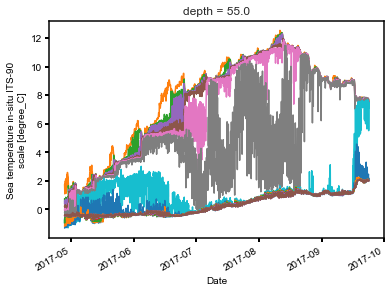

In [25]:
for i in range(0,len(ds.temperature)):
    ds.temperature[i].plot()

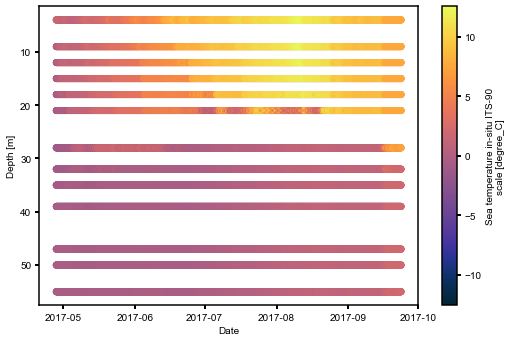

In [26]:
fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(8.5,5.5))
ds.plot.scatter(x='time',y='depth',hue='temperature', cmap=cmocean.cm.thermal, ax=ax1)
ax1.invert_yaxis()


<ipython-input-27-c2f8f593d944>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(ds.time,ds.depth,ds.temperature,


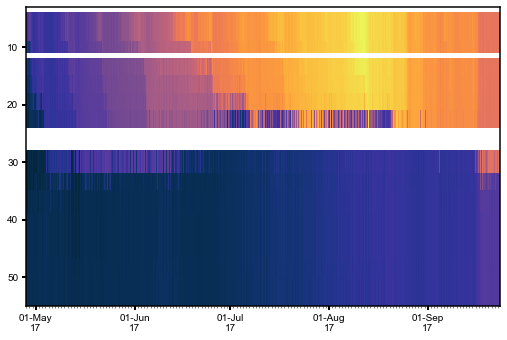

In [27]:
#or better yet
fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(8.5,5.5))

ax1.pcolormesh(ds.time,ds.depth,ds.temperature,
                     cmap=cmocean.cm.thermal)

ax1.invert_yaxis()


xfmt = mdates.DateFormatter('%d-%b\n%y')
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_minor_locator(DayLocator())
